# Import Library and Data

Link Data: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [94]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import datetime as dt
from plotly.offline import iplot,plot
import cufflinks as cf
cf.go_offline()
import plotly.graph_objs as go
import plotly.express as px
from dateutil.relativedelta import *
from plotly.subplots import make_subplots
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
df1 = pd.read_csv('olist_customers_dataset.csv', delimiter=',')
df2 = pd.read_csv('olist_geolocation_dataset.csv', delimiter=',')
df3 = pd.read_csv('olist_order_items_dataset.csv', delimiter=',')
df4 = pd.read_csv('olist_order_payments_dataset.csv', delimiter=',')
df5 = pd.read_csv('olist_order_reviews_dataset.csv', delimiter=',')
df6 = pd.read_csv('olist_orders_dataset.csv', delimiter=',')
df7 = pd.read_csv('olist_products_dataset.csv', delimiter=',')
df8 = pd.read_csv('olist_sellers_dataset.csv', delimiter=',')
df9 = pd.read_csv('product_category_name_translation.csv', delimiter=',')

In [3]:
df1 = df1.rename(columns = {'customer_zip_code_prefix':'zipcode'})

In [4]:
df2 = df2.rename(columns = {'geolocation_zip_code_prefix':'zipcode'})

# Exploratory Data Analysis

In [5]:
data_sales = pd.merge(pd.merge(df6,df3,on="order_id"),df1,on="customer_id")

In [6]:
data_sales = data_sales.merge(df7,on='product_id')

In [7]:
data_sales = data_sales[["order_id","order_purchase_timestamp","order_status","customer_unique_id","customer_city",
                         "product_id","price"]]

## Check Data

In [8]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  112650 non-null  object 
 1   order_purchase_timestamp  112650 non-null  object 
 2   order_status              112650 non-null  object 
 3   customer_unique_id        112650 non-null  object 
 4   customer_city             112650 non-null  object 
 5   product_id                112650 non-null  object 
 6   price                     112650 non-null  float64
dtypes: float64(1), object(6)
memory usage: 6.9+ MB


- Since `order_purchase_timestamp` is still an object type, it need to be changed to datetime type

In [9]:
data_sales['order_purchase_timestamp'] = data_sales['order_purchase_timestamp'].astype('datetime64')

In [10]:
data_sales.isna().sum()

order_id                    0
order_purchase_timestamp    0
order_status                0
customer_unique_id          0
customer_city               0
product_id                  0
price                       0
dtype: int64

- There are no null data

In [11]:
data_sales['order_id'].value_counts()

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
7a958cf333909948af12322dae6f17d2     1
47b1306236d4ab3e15acd0a96e7f341b     1
fc7ff0e22c4d9fc5789816ee0131296b     1
ec7d99eece03a8b60c61f6a9ca504094     1
66dea50a8b16d9b4dee7af250b4be1a5     1
Name: order_id, Length: 98666, dtype: int64

- There are duplicates in `order_id` due to join to table products
- To calculate `Frequency`, we need to use `Count Unique` for orders

# Data Visualization 

## Order Status

In [12]:
data_order_status = data_sales.groupby('order_status').agg({
    'order_id':'nunique'
}).reset_index().sort_values(by='order_id', ascending=False)

In [13]:
# data_order_status.iplot(kind = 'bar',x='order_status',y='order_id', title='Total Order by Status',
#                        xTitle = 'Order Status', yTitle = 'Total Order')

fig = px.pie(data_order_status, values='order_id', names='order_status',
             title='Total Order by Status')
fig.show()

- The given pie chart delineates the percentage of order status with 97.8% orders has been delivered
- We can focused on order delivered only to our analysis and customer segmentation

## Sales Summary

In [14]:
data_delivered = data_sales[data_sales['order_status']=='delivered'].reset_index().drop(columns=['index'])

In [15]:
data_delivered['date_sales'] = pd.to_datetime(data_delivered['order_purchase_timestamp'],format='%Y-%m-%d').dt.date.astype("datetime64")

In [16]:
data_delivered['month_sales'] = data_delivered['order_purchase_timestamp'].dt.strftime('%Y-%m-01').astype("datetime64")
# data_delivered['day'] = data_delivered['order_purchase_timestamp'].dt.day

In [17]:
data_sales_growth = data_delivered.groupby(['month_sales']).agg({
    'price':'sum',
    'order_id':'nunique'
}).reset_index()

In [18]:
data_sales_growth['month_sales'] = data_sales_growth['month_sales'].astype('datetime64')

In [19]:
min_date = data_sales_growth['month_sales'].min()
max_date = data_sales_growth['month_sales'].max()

In [20]:
date_range = pd.date_range(start=min_date, end=max_date, freq='MS')

In [21]:
date_range

DatetimeIndex(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [22]:
date = pd.DataFrame(date_range,columns=['month_sales'])

In [23]:
data_sales_growth_pivot = date.merge(data_sales_growth, how='left', on = 'month_sales').fillna(0)

In [24]:
data_sales_growth_pivot['aov'] = (data_sales_growth_pivot['price']//data_sales_growth_pivot['order_id']).fillna(0)

In [25]:
data_sales_growth_pivot[["price","order_id"]].sum() 

price       13221498.11
order_id       96478.00
dtype: float64

In [26]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x = data_sales_growth_pivot['month_sales'],y=data_sales_growth_pivot['price'],name='GMV'),secondary_y=False)
fig.add_trace(go.Scatter(x = data_sales_growth_pivot['month_sales'],y=data_sales_growth_pivot['aov'],name='AOV'),secondary_y=True)

fig.update_layout(title_text="Sales Growth",title_x = 0.47)
fig.update_xaxes(title_text='Month Sales')
fig.update_yaxes(title_text='GMV',secondary_y=False)
fig.update_yaxes(title_text='AOV',secondary_y=True)

In [27]:
price_per_order = data_delivered.groupby("order_id").agg({
    "price":"sum"
}).reset_index()

In [28]:
price_per_order.describe()

,price
count,96478.000000
mean,137.041586
std,209.045198
min,0.850000
25%,45.900000
50%,86.575000
75%,149.900000
max,13440.000000


<AxesSubplot:>

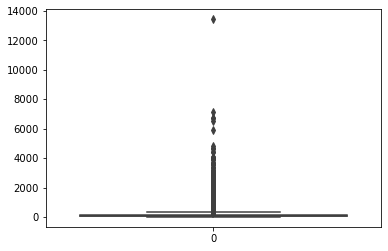

In [29]:
sns.boxplot(data = price_per_order['price'])

In [30]:
qr3 = price_per_order['price'].quantile(0.75)
qr3

149.9

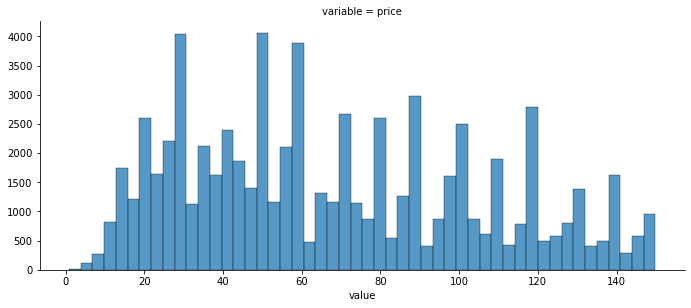

In [31]:
price_data = pd.melt(price_per_order[["price"]][price_per_order["price"]<qr3],value_vars =price_per_order[["price"]])
price_distribution = sns.FacetGrid (price_data, col='variable', col_wrap=4, sharex=False, sharey = False)
price_distribution = price_distribution.map(sns.histplot, 'value')
price_distribution.fig.set_size_inches(40, 5)

- Total Income for our merchant is approximately R\\$13.22 Million with around 96,000 orders
- GMV month-over-month showed significant growth from October 2016 to November 2017, with a slight decrease afterward
- November 2017 was our standout performance with approximately R$987.77K, representing an increase of more than 50% in GMV
- AOV tends to stagnate as the majority spend their money below around R\\$149.90

## Top 10 Product Sales

In [32]:
data_product_sales = data_delivered.groupby('product_id').agg({
    'price':'sum',
    'date_sales':'max'
}).reset_index().sort_values(by='price', ascending=False)

# top10_product_sales = data_product_sales.nlargest(10,'price')

In [33]:
data_product_sales["price_pct"] = (data_product_sales["price"].cumsum().astype("int64")/data_product_sales['price'].sum())*100
data_product_sales[(data_product_sales["price_pct"]<=80)].head(10)

,product_id,price,date_sales,price_pct
23546,bb50f2e236e5eea0100680137654686c,63560.00,2018-08-26,0.480732
13749,6cdd53843498f92890544667809f1595,53652.30,2018-08-21,0.886526
26997,d6160fb7873f184099d9bc95e30376af,45949.35,2017-10-07,1.234058
26436,d1c427060a0f73f6b889a5c7c61f2ac4,45620.56,2018-08-22,1.579110
19290,99a4788cb24856965c36a24e339b6058,42049.66,2018-08-19,1.897145
7881,3dd2a17168ec895c781a9191c1e95ad7,40782.80,2018-08-09,2.205605
4892,25c38557cf793876c5abdd5931f922db,38907.32,2018-04-30,2.499876
12074,5f504b3a1c75b73d6151be81eb05bdc9,37733.90,2018-08-15,2.785274
10616,53b36df67ebb7c41585e8d54d6772e08,37454.63,2018-08-01,3.068563
21617,aca2eb7d00ea1a7b8ebd4e68314663af,37104.30,2018-08-18,3.349197


- Since there are some products in the top 10 that have not had any sales in the last 3 months, coupled with the rapid growth of E-Commerce, we will try to check on products that have made sales in the last three months

In [34]:
data_product_sales_last_three_months = data_delivered[data_delivered["date_sales"]>="2018-06-01"].groupby('product_id').agg({
    'price':'sum'
}).reset_index().sort_values(by='price', ascending=False)

top10_product_sales = data_product_sales_last_three_months.nlargest(10,'price')

In [35]:
top10_product_sales["price_pct"] = (top10_product_sales["price"].cumsum().astype("int64")/top10_product_sales['price'].sum())*100
top10_product_sales[(top10_product_sales["price_pct"]<=80)].head(10)

,product_id,price,price_pct
7299,bb50f2e236e5eea0100680137654686c,18810.00,17.449982
8990,e7cc48a9daff5436f63d3aad9426f28b,15536.00,31.862683
1039,19c91ef95d509ea33eda93495c4d3481,13036.94,43.956142
4255,6cdd53843498f92890544667809f1595,10556.00,53.748912
2755,44fc450365728c413fefc547592626be,9642.00,62.693767
8234,d285360f29ac7fd97640bf0baef03de0,8634.87,70.704431
6567,a92930c327948861c015c919a0bcb4a8,8185.00,78.297631


In [36]:
fig = px.bar(top10_product_sales, x="price", y="product_id",  orientation='h',
#              hover_data=["tip", "size"],
             height=400,
             title='Top 10 Product Sales Last 3 Months')
fig.update_layout(yaxis={'categoryorder':'total ascending'},title_x = 0.5) 

- Based on sales in the last 3 months, there are only 7 Pareto products that we need to monitor in terms of stock and market
- We need to check the market and stock of products that have made it into the top 10 historical sales but have not been in the top 10 for the last 3 months, even if they have had sales during this period
- bb50f2e236e5eea0100680137654686c and 6cdd53843498f92890544667809f1595 remaining consistent as our top products indicates that people are originally aware of them

## Top 10 City Sales

In [37]:
data_city_sales = data_delivered.groupby('customer_city').agg({
    'price':'sum'
}).reset_index().sort_values(by='price', ascending=False)

top10_city_sales = data_city_sales.nlargest(10,'price')

In [38]:
fig = px.bar(top10_city_sales, x="price", y="customer_city",  orientation='h',
#              hover_data=["tip", "size"],
             height=400,
             title='Top 10 City Sales')
fig.update_layout(yaxis={'categoryorder':'total ascending'},title_x = 0.5) 

## Top 10 Customer Sales

In [39]:
data_customer_sales = data_delivered.groupby('customer_unique_id').agg({
    'price':'sum',
    'order_id':'nunique'
}).reset_index().sort_values(by='price', ascending=False)

top10_cust_sales = data_customer_sales.nlargest(10,'price')

In [40]:
fig = px.bar(top10_cust_sales, x="price", y="customer_unique_id",  orientation='h',
#              hover_data=["tip", "size"],
             height=400,
             title='Top 10 Customer Sales')
fig.update_layout(yaxis={'categoryorder':'total ascending'},title_x = 0.5) 

# Customer RFM

## Prepare Data

In [41]:
raw_data_rfm = data_delivered[["order_id","customer_unique_id","price","date_sales"]]

In [42]:
raw_data_rfm = raw_data_rfm[raw_data_rfm["date_sales"]>="2018-01-01"].reset_index().drop(columns="index")

In [43]:
latest_date = raw_data_rfm["date_sales"].max()

In [44]:
def recency (x):
    return (latest_date - x.min()).days
def tenure (x):
    return (x.max() - x.min()).days
def frequency (x):
    return len(set(x))
def generate_rfm (data):
    agg_dict = {
        "date_sales" : [recency,tenure],
        "order_id" : [frequency],
        "price" : "sum"
    }
    
    data_rfm = data.groupby("customer_unique_id").agg(agg_dict)
    data_rfm.columns = ["Recency","Tenure","Frequency","Monetary"]
    return data_rfm

In [45]:
data_rfm = generate_rfm(data = raw_data_rfm)

In [46]:
data_rfm.head()

,Recency,Tenure,Frequency,Monetary
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,111,0,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,114,0,1,18.90
0004bd2a26a76fe21f786e4fbd80607f,146,0,1,154.00
00050ab1314c0e55a6ca13cf7181fecf,131,0,1,27.99
00053a61a98854899e70ed204dd4bafe,182,0,1,382.00


In [47]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51612 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffff5962728ec6157033ef9805bacc48
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    51612 non-null  int64  
 1   Tenure     51612 non-null  int64  
 2   Frequency  51612 non-null  int64  
 3   Monetary   51612 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.0+ MB


## Exploratory Data Analysis - Data RFM

### Check for Data Describe

In [48]:
data_rfm.describe()

,Recency,Tenure,Frequency,Monetary
count,51612.000000,51612.000000,51612.000000,51612.000000
mean,123.379776,0.834690,1.022689,139.853622
std,69.170949,9.435179,0.163189,207.024543
min,0.000000,0.000000,1.000000,0.850000
25%,63.000000,0.000000,1.000000,46.900000
50%,126.000000,0.000000,1.000000,89.490000
75%,183.000000,0.000000,1.000000,150.000000
max,240.000000,230.000000,7.000000,7160.000000


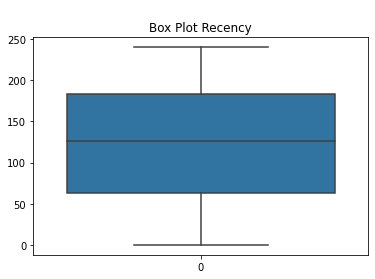

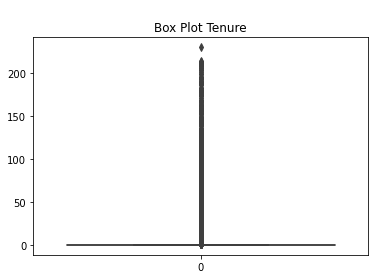

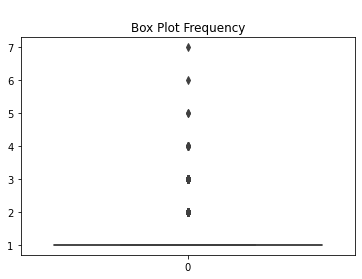

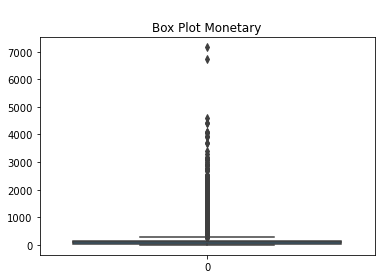

In [49]:
num_col = ['Recency','Tenure','Frequency','Monetary']
for i in num_col:
  plt.figure(figsize=(6,4))
  ax = sns.boxplot(data=data_rfm[i])
  plt.title("\nBox Plot {}".format(i), fontsize=12)
  plt.show()

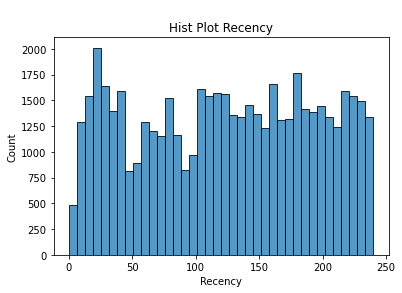

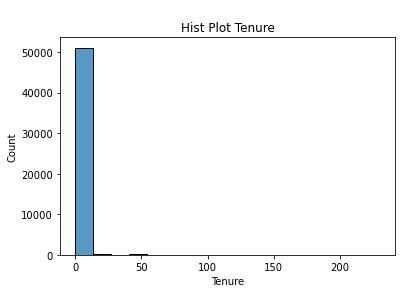

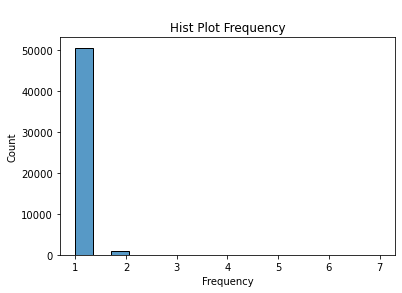

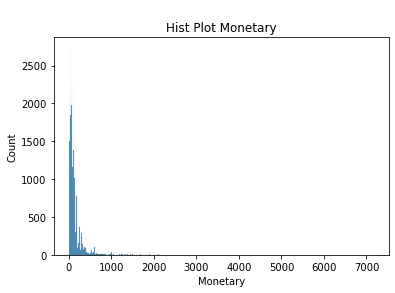

In [50]:
num_col = ['Recency','Tenure','Frequency','Monetary']
for i in num_col:
  plt.figure(figsize=(6,4))
  ax = sns.histplot(data=data_rfm[i])
  plt.title("\nHist Plot {}".format(i), fontsize=12)
  plt.show()

- The given charts show outliers and high skewness for `Frequency`, `Monetary`, and `Tenure` 
- The mean and median for `Frequency` and `Tenure` are similar, so we need a deeper analysis 
- The mean and median for `Monetary` are significantly different, so we need to filter this data

### Check Data for `Frequency`, `Monetary`, and`Tenure`

In [51]:
data_rfm[data_rfm["Frequency"]==1].describe()

,Recency,Tenure,Frequency,Monetary
count,50526.000000,50526.0,50526.0,50526.000000
mean,122.723588,0.0,1.0,137.251596
std,69.180652,0.0,0.0,204.384468
min,0.000000,0.0,1.0,0.850000
25%,63.000000,0.0,1.0,45.900000
50%,125.000000,0.0,1.0,88.000000
75%,182.000000,0.0,1.0,149.900000
max,240.000000,0.0,1.0,7160.000000


In [52]:
data_rfm[data_rfm["Frequency"]>=2].describe()

,Recency,Tenure,Frequency,Monetary
count,1086.000000,1086.000000,1086.000000,1086.000000
mean,153.908840,39.668508,2.078269,260.912486
std,61.429469,51.891278,0.357084,280.166386
min,7.000000,0.000000,2.000000,11.980000
25%,112.250000,0.000000,2.000000,114.000000
50%,171.000000,16.000000,2.000000,182.040000
75%,203.000000,62.000000,2.000000,304.720000
max,240.000000,230.000000,7.000000,4080.000000


In [53]:
(data_rfm["Frequency"][data_rfm["Frequency"]>=2].count()/data_rfm["Frequency"].count())*100

2.1041618228319

In [54]:
data_rfm[data_rfm["Tenure"]==0].describe()

,Recency,Tenure,Frequency,Monetary
count,50868.000000,50868.0,50868.000000,50868.000000
mean,122.969686,0.0,1.006881,137.887374
std,69.199917,0.0,0.084545,204.778837
min,0.000000,0.0,1.000000,0.850000
25%,63.000000,0.0,1.000000,45.900000
50%,125.000000,0.0,1.000000,89.000000
75%,183.000000,0.0,1.000000,149.900000
max,240.000000,0.0,3.000000,7160.000000


In [55]:
data_rfm[data_rfm["Tenure"]>0].describe()

,Recency,Tenure,Frequency,Monetary
count,744.000000,744.000000,744.000000,744.000000
mean,151.418011,57.903226,2.103495,274.287876
std,60.974820,53.617872,0.416728,296.425112
min,7.000000,1.000000,2.000000,11.980000
25%,110.000000,14.000000,2.000000,119.550000
50%,156.000000,41.000000,2.000000,195.120000
75%,203.250000,89.000000,2.000000,319.880000
max,240.000000,230.000000,7.000000,4080.000000


In [56]:
(data_rfm["Tenure"][(data_rfm["Tenure"]==0)&(data_rfm["Frequency"]>=2)].count()/data_rfm["Frequency"][data_rfm["Frequency"]>=2].count())*100

31.491712707182316

In [57]:
(data_rfm[data_rfm["Tenure"]>0].count()/data_rfm.count())*100

Recency      1.441525
Tenure       1.441525
Frequency    1.441525
Monetary     1.441525
dtype: float64

- Only 2.10% of our customer who made 2 or more transaction with 31.49% transaction happened on the same day
- Only 1.44% customer who purchase on a different day
- Upper Bound for `Frequency` and `Tenure` will be the same as median since there are no different between Q1 and Q3
- Since customer barely transaction twice, we will exclue `Tenure` feature
- We will disregard the outliers for `Frequency` since they are below 5% and do not cause any significant difference between mean, median, and upper bound

In [119]:
data_rfm = data_rfm.loc[:, data_rfm.columns!='Tenure']

### Remove Outlier `Monetary`

In [120]:
def drop_outlier(data,cols):
    for col in cols:
        q1, q3 = np.quantile(data[col], q=[0.25, 0.75])
        ub = q3+1.5*(q3-q1)
        lb = q1-1.5*(q3-q1)
        
        data_clean = data[(data[col]>=lb)&(data[col]<=ub)]
        data_outlier = data[(data[col]<lb)|(data[col]>ub)]
    
    return data_clean,data_outlier
        

In [121]:
data_rfm_clean,data_outlier = drop_outlier(data_rfm,["Monetary"])

In [122]:
data_rfm_clean.describe()

,Recency,Frequency,Monetary
count,47332.000000,47332.000000,47332.000000
mean,123.339052,1.017958,95.744050
std,69.328873,0.139171,66.242577
min,0.000000,1.000000,0.850000
25%,63.000000,1.000000,43.900000
50%,126.000000,1.000000,79.900000
75%,183.000000,1.000000,133.992500
max,240.000000,5.000000,304.480000


In [123]:
data_outlier.describe()

,Recency,Frequency,Monetary
count,4280.000000,4280.000000,4280.000000
mean,123.830140,1.075000,627.656012
std,67.406084,0.322457,457.031810
min,0.000000,1.000000,304.800000
25%,67.000000,1.000000,367.000000
50%,126.000000,1.000000,478.000000
75%,181.000000,1.000000,699.900000
max,239.000000,7.000000,7160.000000


## K-Means Clustering

### Normalize the Data

- Since K-Means algorithm uses Ecludian Distance that is highly prone to feature size differences, we will normalize the data to ignore it and improve our accuracy
- We are gonna check whether data is normal distributed or not using Q-Q Plots

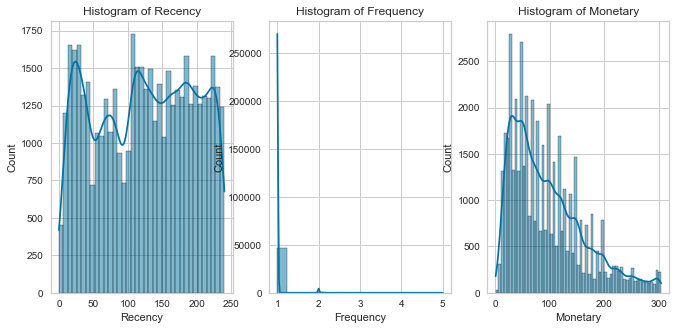

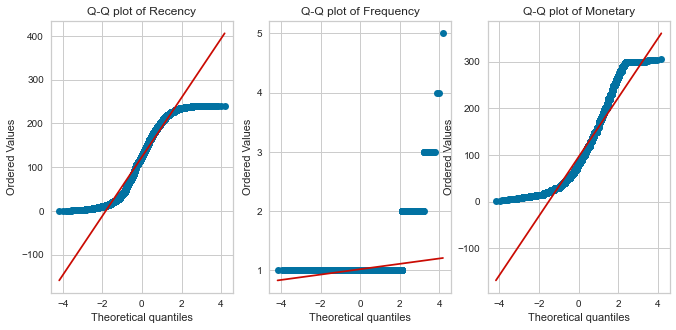

In [124]:
# Histogram
plt.figure(figsize=(15, 5))
for i, column in enumerate(data_rfm_clean.columns, 1):
    plt.subplot(1, 4, i)
    sns.histplot(data_rfm_clean[column], kde=True)
    plt.title(f'Histogram of {column}')
plt.show()

# Q-Q plot
plt.figure(figsize=(15, 5))
for i, column in enumerate(data_rfm_clean.columns, 1):
    plt.subplot(1, 4, i)
    stats.probplot(data_rfm_clean[column], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {column}')
plt.show()

- Dots on the tail for all of the feature isn't allign with the z-score line
- Dots on the head for `Recency` and `Monetary` isn't allign with the z-score line
- Based on the Q-Q plots, it can be conclude that all of the feature is not normal distributed which we will use min-max scaler to reduce the error cause by feature size differences

In [125]:
def minmax_scaler(data):
    scaler = MinMaxScaler()
    transform = scaler.fit_transform(data)

    return transform

def data_minmaxscaler(data,transform):
    data_scaler = pd.DataFrame(transform)
    data_scaler.index = data.index
    data_scaler.columns = data.columns
    
    return data_scaler

In [126]:
transform = minmax_scaler(data_rfm_clean)
data_rfm_scaled = data_minmaxscaler(data_rfm_clean,transform)

### Elbow Method

- We will try to use Elbow Method in order to determine number of clusters

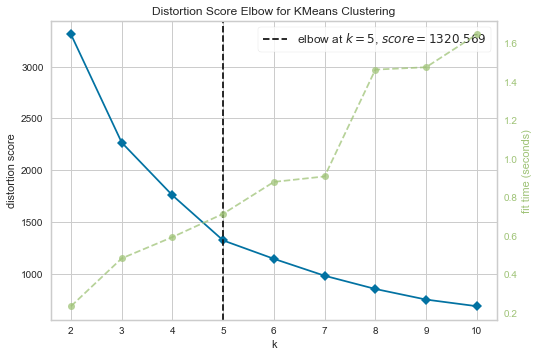

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [127]:
elbow_model = KElbowVisualizer(KMeans(),k=10)
elbow_model.fit(data_model)
elbow_model.show()

- Even though there are no sharp bending on this plot, this methods approximately gives `n_cluster = 5`
- We decide to use `n_cluster = 5` (Assumption: have no limit marketing budget)

### K-Means

In [130]:
model = KMeans(n_clusters=5, random_state=1000,n_init = 10)
model.fit_predict(data_rfm_scaled)
#new column for cluster labels associated with each subject
data_rfm_clean['clusters'] = model.labels_

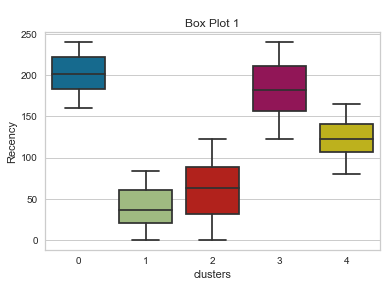

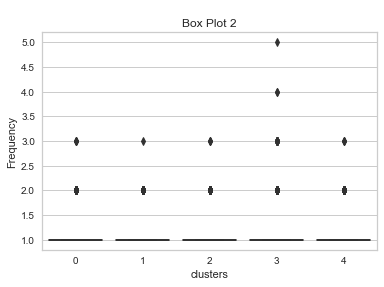

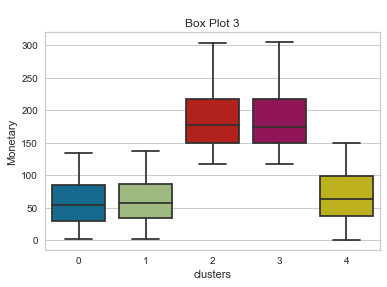

In [134]:
for i, column in enumerate(data_rfm_clean.columns[:-1], 1):
  plt.figure(figsize=(6,4))
  ax = sns.boxplot(x='clusters', y=data_rfm_clean[column], data=data_rfm_clean)
  plt.title("\nBox Plot {}".format(i), fontsize=12)
  plt.show()

In [133]:
# Calculate average values for each RFM_Level, and return a size of each segment
data_rfm_clean.groupby('clusters').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'clusters':'count',
}).round(2)

,Recency,Frequency,Monetary,clusters
clusters,,,,
0,201.79,1.01,59.71,11621
1,39.41,1.00,61.45,11242
2,62.10,1.02,186.11,5952
3,182.61,1.06,186.28,6651
4,123.52,1.01,67.45,11866


In [140]:
def q3(x):
    return x.quantile(0.75)

data_rfm_clean.groupby('clusters')["Monetary"].agg({
    'median', q3
}).round(2)

,median,q3
clusters,,
0,54.00,85.9
1,56.90,86.5
2,178.00,218.0
3,174.90,217.0
4,63.99,98.9


**General Recomendation**

- Focus clustering on Recency and Monetary factors, as most of the customers are one-time purchasers.
- Provide recommendations to encourage customer retention.

**Cluster 0** -> Churned Customers 

---
Recommendation:
- **Ignore Customers**: Consider deprioritizing customers with high recency but low monetary value.

**Cluster 1** -> Potential Customers

---
Recommendation:

- **Encourage Repeat Purchases**: Offer vouchers or discounts for the second transaction to promote customer retention with \$86.5 minimum purchase, specifically for first-time purchasers.

- **Promote the Loyalty Program**: Highlight our loyalty program to attract and engage customers, encouraging them to return for future purchases.

**Cluster 2** -> Best Customers

---
Recommendation:
- **Customer Loyalty Program**: Implement a customer loyalty program that offers rewards and benefits to encourage customer retention.
- **Product Recommendation**: Provide product recommendations based on their preferences and previous purchases at the beginning of the page to enhance the shopping experience and make it easier for customers.
- **Campaign**: Launch a cross-selling or up-selling campaign to increase the average order value.

**Cluster 3** -> High Potential Churn

---
Recommendation: <br>
- **Surveys or Feedback**: Conduct surveys or collect feedback to understand the needs of customers who have spent significantly. This will help tailor your approach to address their specific requirements.
- **Promotion**: Offer discounts and benefits on their first purchase after potential churn as well as promote your loyalty program to incentivize their return.
- **Target Ads**: Run targeted ads featuring campaigns that are relevant to their personalized preferences or previous purchases.

**Cluster 4** -> At Risk Customers

---
Recommendation:
- **Satisfaction Survey**: Conduct customer satisfaction surveys to identify and address any issues that may be causing dissatisfaction
- **Promote the Loyalty Program**: Highlight our loyalty program to attract and engage customers, encouraging them to return for future purchases.